# StyleCLIP

Редактирование изображений -- очень важная и интересная задача в мире генеративных моделей. В этом ноутбуке мы с вами попробуем решить эту задачу на основе работы [StyleCLIP](https://arxiv.org/abs/2103.17249).

Данный метод позволяет редактировать изображения, сгенерированные [StyleGAN2](https://github.com/rosinality/stylegan2-pytorch), используя текстовые описания. Например, вы можете взять фотографию человека и с помощью текстовой подсказки "сделать волосы кудрявыми" изменить прическу на фотографии. Основная идея данной работы в том, чтобы "подвинуть" изначальный латент так, чтобы сгенерированное из него изображение лучше соответствовало предложенному промпту. Авторы предлагают два основных подхода:

- Оптимизация латентного вектора на основе CLIP Loss

- Обучение специального Mapper для сдвига

Более подробно про эти два подхода можно почитать в самой стате [StyleCLIP](https://arxiv.org/abs/2103.17249).

Мы с вами рассмотрим только одну часть предложенного метода, а именно оптимизацию для редактирования. Как уже было сказано, StyleCLIP оптимизирует латентный вектор [StyleGAN2](https://arxiv.org/abs/1912.04958) для более точного соотвествия заданному промпту.

Идея StyleCLIP с оптимизацией отображена на изображении ниже.




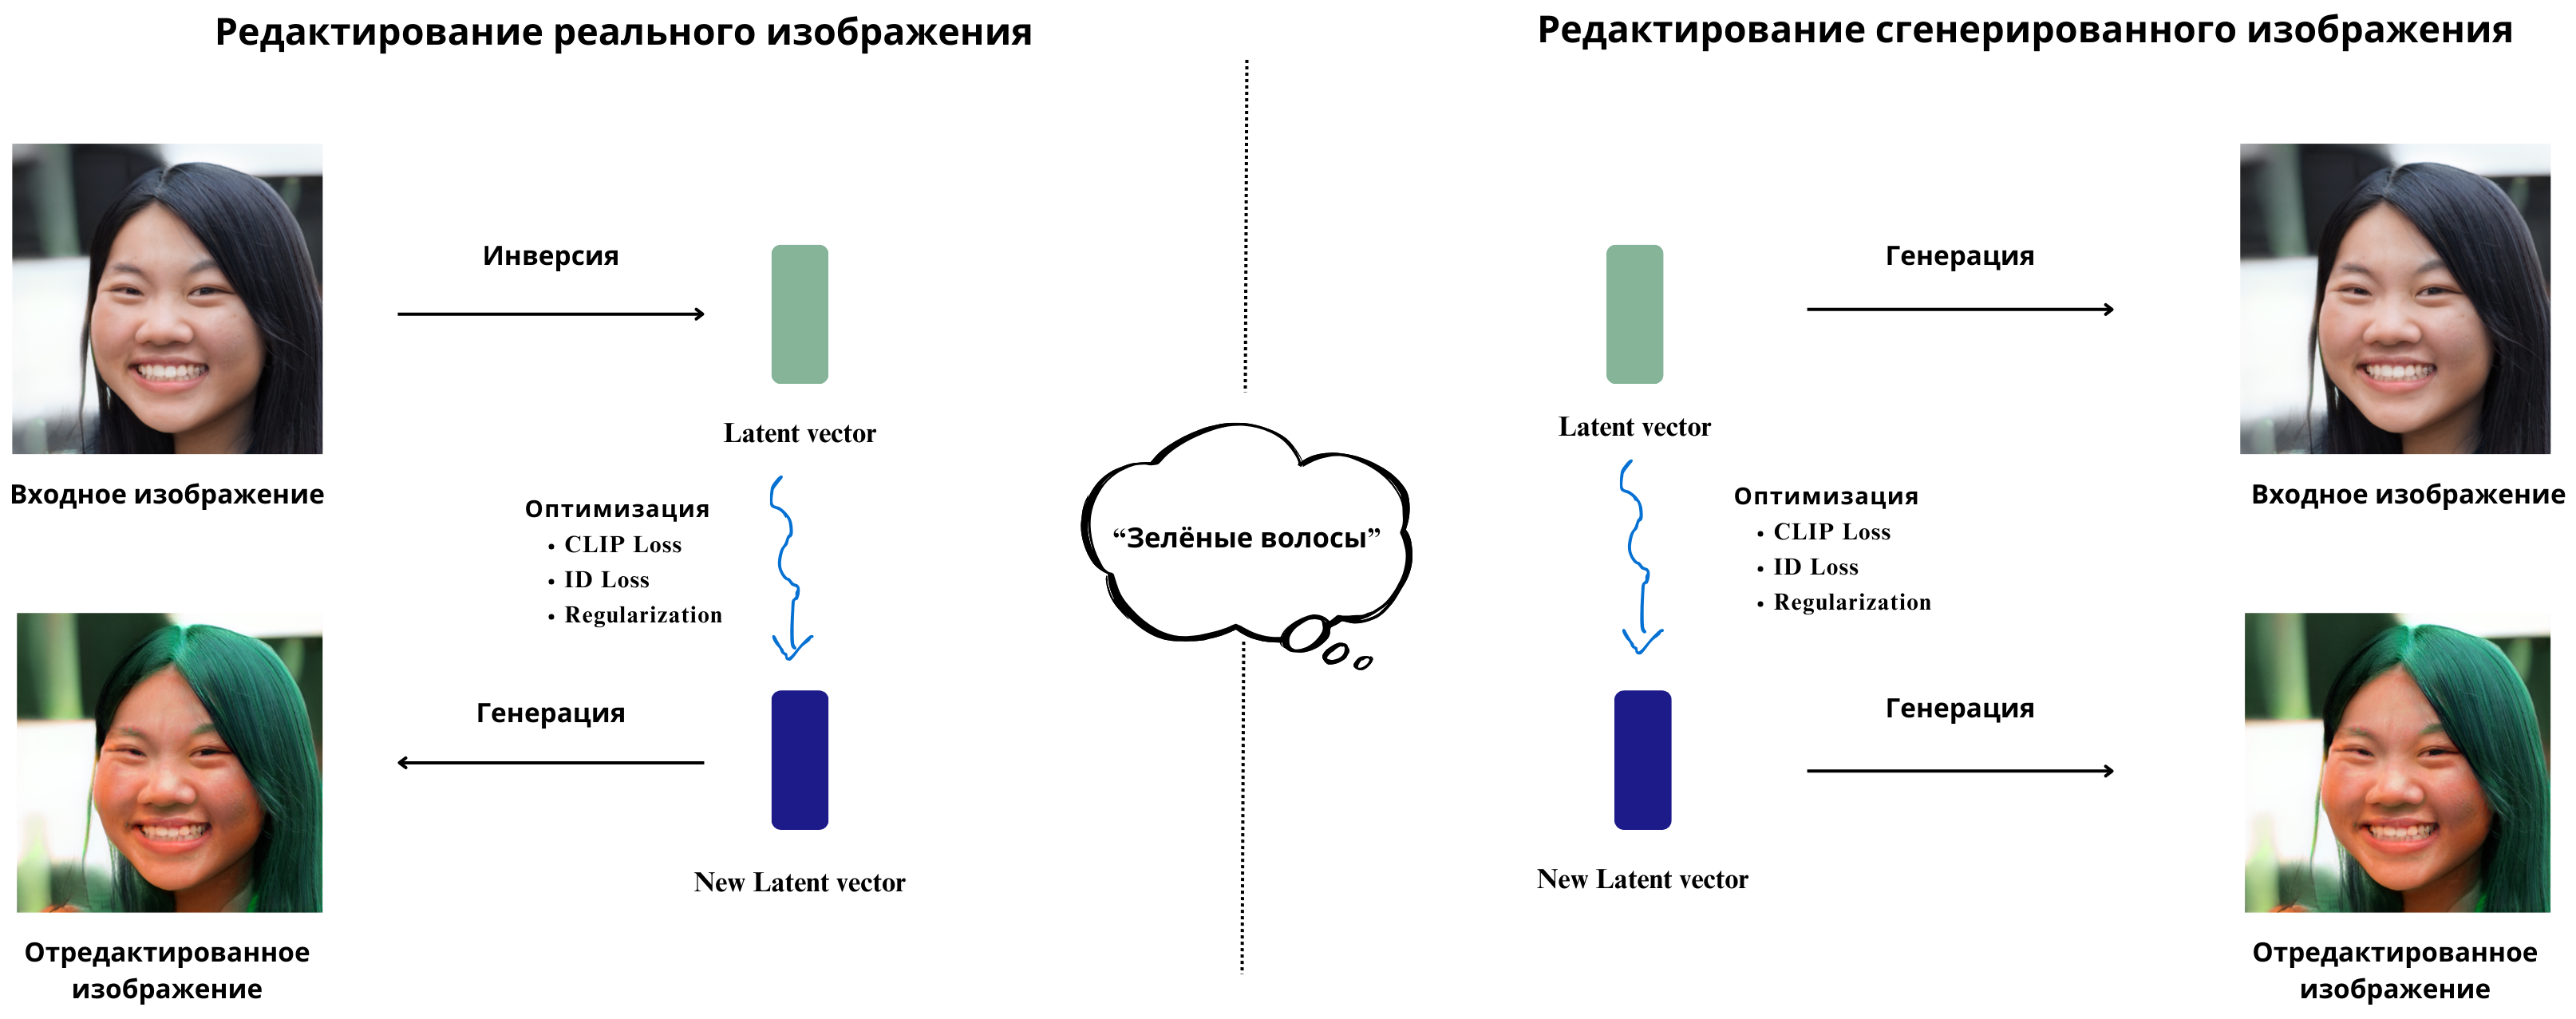

Наш план будет состоять в следующем:

1. Подготовка всех моделей для оптимизации

2. Реализация всех необходимых функций потерь:

  - CLIP Loss (1 балла)
  - ID Loss (1 балла)

3. Подготовка кода оптимизации (2 балла)

4. Выводы из полученных результатов (1 балл)

Давайте же попробуем написать код для этой оптимизации!

## Установка необходимых библиотек и подготовка окружения
Начнем с установки необходимых библиотек и клонирования репозитория StyleCLIP, чтобы использовать его методы.

In [93]:
# Установка необходимых библиотек

# Установка зависимостей
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
# Установка дополнительных библиотек
!pip install Ninja

# Импорт нужных библиотек
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.utils import save_image
import clip
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-b0xhs20g
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-b0xhs20g
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [2]:
!git clone https://github.com/rosinality/stylegan2-pytorch.git
%cd stylegan2-pytorch/
!rm -rf build

import os
os.environ['TORCH_CUDA_ARCH_LIST'] = '8.6'  # или другой, если ваша видеокарта не RTX 30xx
os.environ['FORCE_CUDA'] = '1'

!python setup.py install

fatal: destination path 'stylegan2-pytorch' already exists and is not an empty directory.
/content/stylegan2-pytorch
python3: can't open file '/content/stylegan2-pytorch/setup.py': [Errno 2] No such file or directory


In [3]:
# Будем работать с конкретным сидом
torch.manual_seed(345)

## Основная идея статьи


Как уже было сказано, мы хотим редактировать изображение с помощью текста. Для этого будем использовать [CLIP](https://paperswithcode.com/method/clip) модель для некоторого гайданса в процессе оптимизации.

Задачу мы хотим построить следующим образом: имея исходный латентный вектор $w \in W$ мы хотим оптимизировать его под текстовый запрос $t$. Давайте подгрузм нашу модель и сгенерируем картинку для дальнейшей оптимизации.

Для работы со StyleGAN-2 нам для начала нужно скачать модель. Для скачивания мы используем следующий код:

In [4]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# downloads StyleGAN's weights and facial recognition network weights
ids = ['1EM87UquaoQmk17Q8d5kYIAHqu0dkYqdT', '1N0MZSqPRJpLfP4mFQCS14ikrVSe8vQlL']
for file_id in ids:
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.FetchMetadata(fetch_all=True)
  downloaded.GetContentFile(downloaded.metadata['title'])

In [5]:
# Установка зависимостей

import torch
import os

# Указываем архитектуру GPU
os.environ['TORCH_CUDA_ARCH_LIST'] = '7.5'

# Проверяем устройство
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Используется устройство: {device}")
print(f"Версия PyTorch: {torch.__version__}")
print(f"Версия CUDA: {torch.version.cuda}")

# Фиксируем seed
seed = 3456
torch.manual_seed(seed)

# Загрузка модели
try:
    from model import Generator
    latent_dim = 512
    generator = Generator(size=1024, style_dim=latent_dim, n_mlp=8).to(device)

    # Загрузка весов
    state_dict = torch.load('/content/stylegan2-pytorch/stylegan2-ffhq-config-f.pt', map_location=device)
    generator.load_state_dict(state_dict['g_ema'])
    generator.eval()

    print("Генератор StyleGAN2 успешно загружен!")
except Exception as e:
    print(f"Ошибка при загрузке модели: {str(e)}")

Используется устройство: cuda
Версия PyTorch: 2.6.0+cu124
Версия CUDA: 12.4
Генератор StyleGAN2 успешно загружен!


### Функция для генерации изображения из латентного вектора
Эта функция генерирует изображение из латентного вектора $z \in Z$ ($w \in W$), что нам пригодится для визуализации процесса редактирования.

Device: cuda


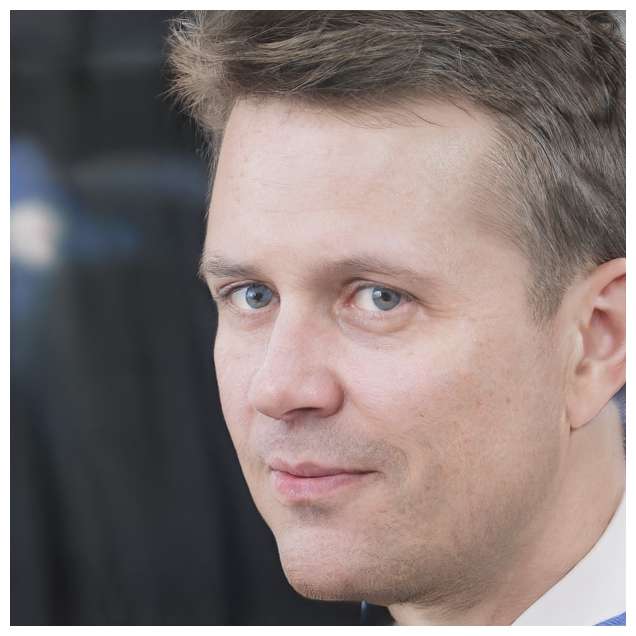

In [72]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")


# Создаём генератор
generator = Generator(size=1024, style_dim=512, n_mlp=8).to(device)
generator.load_state_dict(state_dict['g_ema'])
generator.eval()

# === ШАГ 3: Генерация и отображение изображения ===
latent_z = torch.randn(10000, 512, device=device)
latent_z_generated = latent_z.mean(0, keepdim=True)

with torch.no_grad():
    target_img, _ = generator([latent_z_generated], input_is_latent=False)

def show_image(img_tensor):
    img = img_tensor[0].permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

show_image(target_img)

## Задача оптимизации

Теперь давайте подронее сформулируем задачу оптимизации.

Нам необходимо следующее:

- Отредактированное изображение соответствует текстовому запросу

- Сохраняет identity изначального человека.

Авторы предлагают следующий лосс для оптимизации:

$$\arg \min_{w \in W} D_{\text{CLIP}}(G(w), t) + \lambda_2 \|w - w_s\|_2 + \lambda_{\text{ID}} L_{\text{ID}}(w)
$$

Давайте разберёмся с каждой частью подробнее.

### CLIP loss

Начнём мы с CLIP loss.

 $D_{\text{CLIP}}$ — косинусное расстояние между эмбеддингами [CLIP](https://habr.com/ru/articles/539312/) для двух аргументов.

$$D_{\text{CLIP}}(G(w), t) = 1 - \frac{\langle E_{\text{CLIP}}(G(w)) \cdot E_{\text{CLIP}}(t) \rangle }{\|E_{\text{CLIP}}(G(w))\| \cdot \|E_{\text{CLIP}}(t)\|}$$


In [83]:
import torch
import clip


class CLIPLoss(torch.nn.Module):
    def __init__(self, device=None):
        super().__init__()
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        self.model, _ = clip.load("ViT-B/32", device=self.device)
        self.model.eval()

        self.resize = torch.nn.Upsample(size=(224, 224), mode='bilinear')
        self.normalize = torch.nn.functional.normalize

        for param in self.model.parameters():
            param.requires_grad = False

    def preprocess_image(self, image):
        """Приводим изображение StyleGAN к формату CLIP"""
        image = (image + 1) / 2

        image = self.resize(image)

        image = torch.clamp(image, 0, 1)
        return image

    def forward(self, image, text):
        if isinstance(text, str):
            text = clip.tokenize([text]).to(self.device)

        image = self.preprocess_image(image)

        image_features = self.model.encode_image(image)
        text_features = self.model.encode_text(text)

        image_features = self.normalize(image_features, dim=-1)
        text_features = self.normalize(text_features, dim=-1)

        similarity = (image_features @ text_features.T).mean()
        return 1 - similarity

In [84]:
clip_loss = CLIPLoss(device=device)

### ID loss

Для сохранения identity человека использует специально предобученную модель [ArcFace](https://arxiv.org/abs/1801.07698), которая по фотографии вычисляет некоторые характерные для человека embedding вектора. Затем нам необходимо посчитать косинусное расстояние между ожидаемым embedding вектором и тем, что получается в процессе оптимизации:

$$ L_{\text{ID}}(w) = 1 - \langle R(G(w_s)), R(G(w)) \rangle $$

Обратите внимание, что здесь не используется дополнительная нормировка


Давайте подгрузим нашу модель и реализуем желаемую функцию потерь.


### Подгрузка модели

Далее у нас будет подгрузка самой модели, позаимствованная из репозитория [StyleCLIP](https://github.com/orpatashnik/StyleCLIP/blob/main/models/facial_recognition/helpers.py). Вы можете более подробно ознакомиться с кодом этой модели ниже, но мы не будем заострять на ней внимание.


In [26]:
from torch.nn import Linear, Conv2d, BatchNorm1d, BatchNorm2d, PReLU, Dropout, Sequential, Module

"""
Modified Backbone implementation from [TreB1eN](https://github.com/TreB1eN/InsightFace_Pytorch)
"""
from collections import namedtuple
import torch
from torch.nn import Conv2d, BatchNorm2d, PReLU, ReLU, Sigmoid, MaxPool2d, AdaptiveAvgPool2d, Sequential, Module

"""
ArcFace implementation from [TreB1eN](https://github.com/TreB1eN/InsightFace_Pytorch)
"""


class Flatten(Module):
	def forward(self, input):
		return input.view(input.size(0), -1)


def l2_norm(input, axis=1):
	norm = torch.norm(input, 2, axis, True)
	output = torch.div(input, norm)
	return output


class Bottleneck(namedtuple('Block', ['in_channel', 'depth', 'stride'])):
	""" A named tuple describing a ResNet block. """


def get_block(in_channel, depth, num_units, stride=2):
	return [Bottleneck(in_channel, depth, stride)] + [Bottleneck(depth, depth, 1) for i in range(num_units - 1)]


def get_blocks(num_layers):
	if num_layers == 50:
		blocks = [
			get_block(in_channel=64, depth=64, num_units=3),
			get_block(in_channel=64, depth=128, num_units=4),
			get_block(in_channel=128, depth=256, num_units=14),
			get_block(in_channel=256, depth=512, num_units=3)
		]
	elif num_layers == 100:
		blocks = [
			get_block(in_channel=64, depth=64, num_units=3),
			get_block(in_channel=64, depth=128, num_units=13),
			get_block(in_channel=128, depth=256, num_units=30),
			get_block(in_channel=256, depth=512, num_units=3)
		]
	elif num_layers == 152:
		blocks = [
			get_block(in_channel=64, depth=64, num_units=3),
			get_block(in_channel=64, depth=128, num_units=8),
			get_block(in_channel=128, depth=256, num_units=36),
			get_block(in_channel=256, depth=512, num_units=3)
		]
	else:
		raise ValueError("Invalid number of layers: {}. Must be one of [50, 100, 152]".format(num_layers))
	return blocks


class SEModule(Module):
	def __init__(self, channels, reduction):
		super(SEModule, self).__init__()
		self.avg_pool = AdaptiveAvgPool2d(1)
		self.fc1 = Conv2d(channels, channels // reduction, kernel_size=1, padding=0, bias=False)
		self.relu = ReLU(inplace=True)
		self.fc2 = Conv2d(channels // reduction, channels, kernel_size=1, padding=0, bias=False)
		self.sigmoid = Sigmoid()

	def forward(self, x):
		module_input = x
		x = self.avg_pool(x)
		x = self.fc1(x)
		x = self.relu(x)
		x = self.fc2(x)
		x = self.sigmoid(x)
		return module_input * x


class bottleneck_IR(Module):
	def __init__(self, in_channel, depth, stride):
		super(bottleneck_IR, self).__init__()
		if in_channel == depth:
			self.shortcut_layer = MaxPool2d(1, stride)
		else:
			self.shortcut_layer = Sequential(
				Conv2d(in_channel, depth, (1, 1), stride, bias=False),
				BatchNorm2d(depth)
			)
		self.res_layer = Sequential(
			BatchNorm2d(in_channel),
			Conv2d(in_channel, depth, (3, 3), (1, 1), 1, bias=False), PReLU(depth),
			Conv2d(depth, depth, (3, 3), stride, 1, bias=False), BatchNorm2d(depth)
		)

	def forward(self, x):
		shortcut = self.shortcut_layer(x)
		res = self.res_layer(x)
		return res + shortcut


class bottleneck_IR_SE(Module):
	def __init__(self, in_channel, depth, stride):
		super(bottleneck_IR_SE, self).__init__()
		if in_channel == depth:
			self.shortcut_layer = MaxPool2d(1, stride)
		else:
			self.shortcut_layer = Sequential(
				Conv2d(in_channel, depth, (1, 1), stride, bias=False),
				BatchNorm2d(depth)
			)
		self.res_layer = Sequential(
			BatchNorm2d(in_channel),
			Conv2d(in_channel, depth, (3, 3), (1, 1), 1, bias=False),
			PReLU(depth),
			Conv2d(depth, depth, (3, 3), stride, 1, bias=False),
			BatchNorm2d(depth),
			SEModule(depth, 16)
		)

	def forward(self, x):
		shortcut = self.shortcut_layer(x)
		res = self.res_layer(x)
		return res + shortcut


class Backbone(Module):
	def __init__(self, input_size, num_layers, mode='ir', drop_ratio=0.4, affine=True):
		super(Backbone, self).__init__()
		assert input_size in [112, 224], "input_size should be 112 or 224"
		assert num_layers in [50, 100, 152], "num_layers should be 50, 100 or 152"
		assert mode in ['ir', 'ir_se'], "mode should be ir or ir_se"
		blocks = get_blocks(num_layers)
		if mode == 'ir':
			unit_module = bottleneck_IR
		elif mode == 'ir_se':
			unit_module = bottleneck_IR_SE
		self.input_layer = Sequential(Conv2d(3, 64, (3, 3), 1, 1, bias=False),
									  BatchNorm2d(64),
									  PReLU(64))
		if input_size == 112:
			self.output_layer = Sequential(BatchNorm2d(512),
			                               Dropout(drop_ratio),
			                               Flatten(),
			                               Linear(512 * 7 * 7, 512),
			                               BatchNorm1d(512, affine=affine))
		else:
			self.output_layer = Sequential(BatchNorm2d(512),
			                               Dropout(drop_ratio),
			                               Flatten(),
			                               Linear(512 * 14 * 14, 512),
			                               BatchNorm1d(512, affine=affine))

		modules = []
		for block in blocks:
			for bottleneck in block:
				modules.append(unit_module(bottleneck.in_channel,
										   bottleneck.depth,
										   bottleneck.stride))
		self.body = Sequential(*modules)

	def forward(self, x):
		x = self.input_layer(x)
		x = self.body(x)
		x = self.output_layer(x)
		return l2_norm(x)


def IR_50(input_size):
	"""Constructs a ir-50 model."""
	model = Backbone(input_size, num_layers=50, mode='ir', drop_ratio=0.4, affine=False)
	return model


def IR_101(input_size):
	"""Constructs a ir-101 model."""
	model = Backbone(input_size, num_layers=100, mode='ir', drop_ratio=0.4, affine=False)
	return model


def IR_152(input_size):
	"""Constructs a ir-152 model."""
	model = Backbone(input_size, num_layers=152, mode='ir', drop_ratio=0.4, affine=False)
	return model


def IR_SE_50(input_size):
	"""Constructs a ir_se-50 model."""
	model = Backbone(input_size, num_layers=50, mode='ir_se', drop_ratio=0.4, affine=False)
	return model


def IR_SE_101(input_size):
	"""Constructs a ir_se-101 model."""
	model = Backbone(input_size, num_layers=100, mode='ir_se', drop_ratio=0.4, affine=False)
	return model


def IR_SE_152(input_size):
	"""Constructs a ir_se-152 model."""
	model = Backbone(input_size, num_layers=152, mode='ir_se', drop_ratio=0.4, affine=False)
	return model

### ID loss

Теперь непосредственно реализуем нашу функцию потерь.

In [46]:
class IDLoss(nn.Module):
    def __init__(self, model_weights, device='cuda'):
        super(IDLoss, self).__init__()
        print('Loading ResNet ArcFace')

        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        self.facenet = Backbone(input_size=112, num_layers=50, drop_ratio=0.6, mode='ir_se')

        checkpoint = torch.load(model_weights, map_location=self.device)
        self.facenet.load_state_dict(checkpoint)

        self.pool = torch.nn.AdaptiveAvgPool2d((256, 256))
        self.face_pool = torch.nn.AdaptiveAvgPool2d((112, 112))

        self.facenet.to(self.device)
        self.facenet.eval()

        for param in self.facenet.parameters():
            param.requires_grad = False

    def extract_feats(self, x):
        if x.shape[2] != 256:
            x = self.pool(x)
        x = x[:, :, 35:223, 32:220]
        x = self.face_pool(x)
        x_feats = self.facenet(x)
        return x_feats

    def forward(self, y_hat, y):
        y_feats = self.extract_feats(y.to(self.device)).detach()
        y_hat_feats = self.extract_feats(y_hat.to(self.device))
        sim = torch.sum(y_hat_feats * y_feats, dim=1)
        return 1 - sim.mean()

In [76]:
# Загрузим нашу модель ArcFace
model_path = "/content/stylegan2-pytorch/model_ir_se50.pth"
id_loss = IDLoss(model_path, device)

Loading ResNet ArcFace


## Инициализация латентного вектора и текстовой подсказки
Определим латентный вектор
𝑊
W для исходного изображения и преобразуем текстовую подсказку в вектор с помощью CLIP, что будет служить нашей целью для редактирования.

## Оптимизация для редактирования изображения
Реализуем оптимизацию, используя Adam. На каждом шаге обновляется латентный вектор $w \in W$ для минимизации потерь CLIP, пока результат не будет похож на текстовую подсказку.

Основной псевдокод оптимизации представлен ниже:

```python

for step in range(num_steps):  # <----------- итерируемся по датасету несколько раз
    torch.cuda.empty_cache() # <------------- очищаем кэш модели
    optimizer.zero_grad()  # <------------- обуляем градиенты модели
    image, _ = generator([latent], input_is_latent=True, randomize_noise=False)  # <------------- получаем картинку из StyleGAN-2
    loss = clip_loss + l2_lambda * l2_loss + id_lambda * id_loss
    loss.backward()  # <------------------- считаем градиенты
    optimizer.step()  # <------------------ делаем шаг градиентного спуска
    if convergence:  # <------------------- в случае сходимости выходим из цикла
        break
```

Где полная функция потерь считается по формуле:
$$\arg \min_{w \in W} D_{\text{CLIP}}(G(w), t) + \lambda_2 \|w - w_s\|_2 + \lambda_{\text{ID}} L_{\text{ID}}(w)
$$

Дополнительно сохраните значения лосс функций для дальнейшей визуализации.


In [85]:
# Подготавливаем текстовый промпт для оптимизации, который будет направлять изменение изображения.
text_input = clip.tokenize(["a person with green hair"]).to(device)

# Токенизируем промпт с помощью CLIP tokenizer и перемещаем на устройство (CPU или GPU).
# clip.tokenize: функция из библиотеки CLIP для токенизации текста.
text_inputs = torch.cat([clip.tokenize(prompt)]).to(device)

In [78]:
# Подготовим папку для сохранения результатов
import os
save_dir = "results"
os.makedirs(save_dir, exist_ok=True)

Работать предлагаем в пространстве $W$, давайте преобразуем наш вектор в styleSpace

In [90]:
# Получаем w-вектор из z-вектора с помощью mapping network генератора.
with torch.no_grad():
  latent_w = generator.style(latent_z_generated)

latent = latent_w.detach().clone()
latent.requires_grad = True

In [80]:
%matplotlib inline

In [91]:
num_steps = 200
l2_lambda = 0.01
id_lambda = 0.1

In [96]:
with torch.no_grad():
    truncation_latent = generator.mean_latent(4096)

history = {
    'total': [],
    'clip': [],
    'l2': [],
    'id': [],
    'lr': []
}

latent = latent_z_generated.clone().detach().requires_grad_(True)
optimizer = torch.optim.Adam([latent], lr=0.05, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.9)

for step in tqdm(range(num_steps), desc="Optimizing"):
    optimizer.zero_grad()

    img_gen, _ = generator(
        [latent],
        input_is_latent=True,
        truncation=0.7,
        truncation_latent=truncation_latent,
        randomize_noise=False
    )

    try:
        clip_loss_value = clip_loss(img_gen, text_input)
        l2_loss_value = torch.norm(latent - latent_z_generated)
        id_loss_value = id_loss(img_gen, target_img)

        total_loss = clip_loss_value + l2_lambda*l2_loss_value + id_lambda*id_loss_value

        total_loss.backward()

        torch.nn.utils.clip_grad_norm_([latent], max_norm=1.0)

        optimizer.step()
        scheduler.step()

        with torch.no_grad():
            latent.data = torch.clamp(latent.data, -3, 3)

    except Exception as e:
        print(f"Error at step {step}: {str(e)}")
        break

    history['total'].append(total_loss.item())
    history['clip'].append(clip_loss_value.item())
    history['l2'].append(l2_loss_value.item())
    history['id'].append(id_loss_value.item())
    history['lr'].append(optimizer.param_groups[0]['lr'])

    if step % 25 == 0 or step == num_steps-1:
        print(f"\nStep {step}:")
        print(f"Total: {history['total'][-1]:.4f} | "
              f"CLIP: {history['clip'][-1]:.4f} | "
              f"L2: {history['l2'][-1]:.4f} | "
              f"ID: {history['id'][-1]:.4f} | "
              f"LR: {history['lr'][-1]:.3e}")

        with torch.no_grad():
            fig, ax = plt.subplots(1, 2, figsize=(12, 6))

            edited = img_gen[0].permute(1, 2, 0).cpu().clamp(-1, 1).numpy()
            edited = (edited - edited.min()) / (edited.max() - edited.min())
            ax[0].imshow(edited)
            ax[0].set_title(f"Step {step}: Edited")
            ax[0].axis('off')

            original = target_img[0].permute(1, 2, 0).cpu().numpy()
            original = (original - original.min()) / (original.max() - original.min())
            ax[1].imshow(original)
            ax[1].set_title("Original")
            ax[1].axis('off')
            plt.show()

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(history['total'], label='Total Loss', linewidth=2)
plt.plot(history['clip'], '--', label='CLIP Loss')
plt.plot(history['l2'], '--', label='L2 Loss')
plt.plot(history['id'], '--', label='ID Loss')
plt.xlabel('Step')
plt.ylabel('Loss Value')
plt.title('Loss Components')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.semilogy(history['lr'], color='purple')
plt.xlabel('Step')
plt.ylabel('Learning Rate (log scale)')
plt.title('Learning Rate Schedule')
plt.grid(True)

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

Визуализируйте лоссы в зависимости от step

In [ ]:
# YOUR CODE IS HERE

Сохряним результаты!

In [97]:
import os

filename = prompt

# Save the latents to a .pt file.
latent_path = os.path.join(save_dir, filename + ".pt")
torch.save(latent, latent_path)

# Save the image to a .png file.
image_path = os.path.join(save_dir, filename + ".png")
save_image(img_gen, image_path)


print(f"Ваше изображение и латенты успешно сохранены в папке {save_dir}")

Ваше изображение и латенты успешно сохранены в папке results


### Вывооды

Напишите ваши выводы, что получилось, что нет, почему получилось, почему нет.

Волосы перекрасить удалось, однако изображение сильно отличается от оригинального...